# Necessary Libraries

In [1]:

from dynamicviz import boot, viz, score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import spearmanr
from sklearn.datasets import make_s_curve

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, pairwise_distances
from sklearn.metrics import davies_bouldin_score
from itertools import combinations

# use boostrapping

In [11]:
# Load the datasets
tsne_data = pd.read_csv("embryoid_body_umap_lvrandom_p2000_pc5_Y_matrix.csv")
cell_type_data = pd.read_csv("embryoid_body_cls.csv")
S_X = pd.read_csv("embryoid_body_data_denoise.csv")

# Inspect the first few rows
print(tsne_data.head())
print(cell_type_data.head())


   Unnamed: 0        V1        V2
0           1 -6.511627  5.409598
1           2 -5.837244  4.228592
2           3 -3.949526  4.593604
3           4 -4.099818  4.151329
4           5 -2.937120  3.420073
   Unnamed: 0  cls
0           1  ESC
1           2  ESC
2           3  ESC
3           4  ESC
4           5  ESC


In [13]:
# Merge t-SNE data with cell type labels
tsne_data['cls'] = cell_type_data['cls']
print(tsne_data.head())

   Unnamed: 0        V1        V2  cls
0           1 -6.511627  5.409598  ESC
1           2 -5.837244  4.228592  ESC
2           3 -3.949526  4.593604  ESC
3           4 -4.099818  4.151329  ESC
4           5 -2.937120  3.420073  ESC


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0              ESC
1              ESC
2              ESC
3              ESC
4              ESC
           ...    
31024    NE-1/NS-5
31025          CPs
31026         SMPs
31027         SMPs
31028         SMPs
Name: cls, Length: 31029, dtype: object

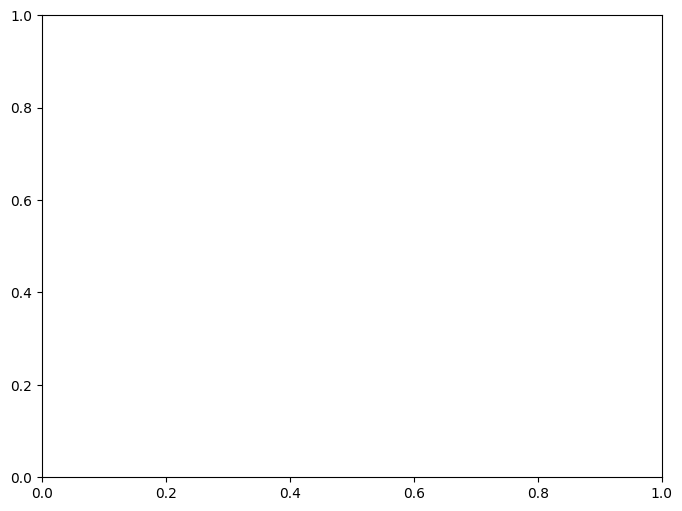

In [14]:
import matplotlib.pyplot as plt

# Scatter plot of t-SNE projections colored by cell type
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_data['V1'], tsne_data['V2'], c=tsne_data['cls'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cell Type")
plt.title("t-SNE Projection of IPSC Data")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


In [16]:
import numpy as np

# Ensure t-SNE data is in the correct format (NumPy array or Pandas DataFrame)
X = tsne_data[['V1', 'V2']].values  # Convert to NumPy array

# Ensure metadata is a Pandas DataFrame
Y = tsne_data[['cls']]

print("X shape:", X.shape)  # Should be (n_samples, 2)
print("Y shape:", Y.shape)  # Should be (n_samples, 1)


X shape: (31029, 2)
Y shape: (31029, 1)


In [17]:
from dynamicviz import boot

# Ensure the DataFrame has reset indices (this avoids index mismatch issues)
tsne_data = tsne_data.reset_index(drop=True)

# Extract t-SNE projections and metadata again
X = tsne_data[['V1', 'V2']].values
Y = tsne_data[['cls']]

# Generate bootstrap samples
try:
    out = boot.generate(X, Y=Y, method="umap", B=4, random_seed=42, random_state=42)
    print(out.head())  # Check the output structure
except TypeError as e:
    print("Error encountered:", e)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 4/4 [01:02<00:00, 15.74s/it]

          x1         x2  original_index  bootstrap_number  cls
0  -4.041532 -14.607646               0                -1  ESC
1 -10.525163 -11.484741               1                -1  ESC
2  -1.661248 -12.847890               2                -1  ESC
3  -3.138441 -12.246562               3                -1  ESC
4  -4.655689  -9.028387               4                -1  ESC


Setting up neighborhoods...
--- 2903.9570429325104 seconds ---
Populating distances...
--- 396.2949912548065 seconds ---
Computing mean pairwise distance for normalization...
--- 20.003920078277588 seconds ---
Computing variance scores...
--- 37.011213064193726 seconds ---


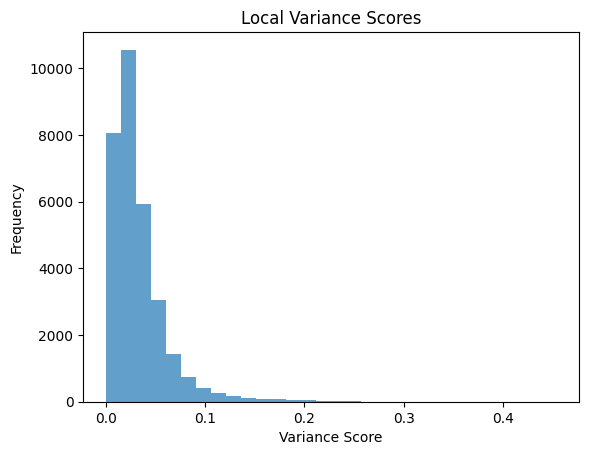

In [18]:
# Compute local variance scores (you need to provide the original high-dimensional dataset, S_X)
variance_scores_local = score.variance(out, method="local", X_orig=S_X, k=50)

# Visualize local variance scores
plt.hist(variance_scores_local, bins=30, alpha=0.7)
plt.title("Local Variance Scores")
plt.xlabel("Variance Score")
plt.ylabel("Frequency")
plt.show()


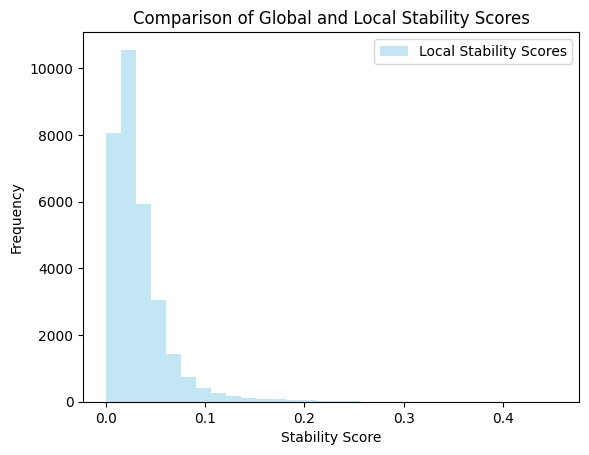

In [20]:
#Compare Global and Local Stability Scores
#plt.hist(variance_scores, bins=30, alpha=0.5, label="Global Stability Scores", color='orange')
plt.hist(variance_scores_local, bins=30, alpha=0.5, label="Local Stability Scores", color='skyblue')
plt.title("Comparison of Global and Local Stability Scores")
plt.xlabel("Stability Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


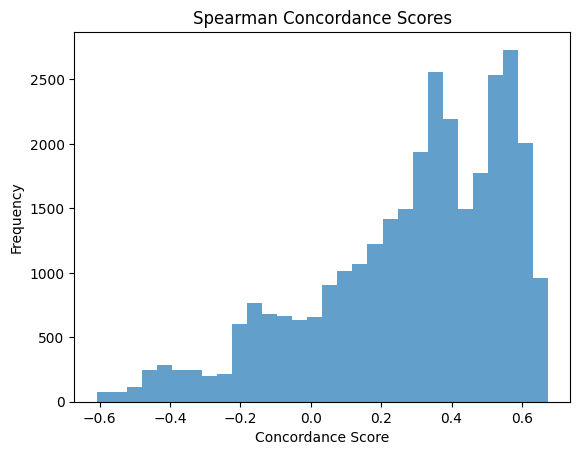

In [24]:
# Ensure S_X is a NumPy array
#S_X = S_X.values 

# Compute Spearman concordance scores
concordance_scores_spearman = score.concordance(out, S_X, method="spearman", bootstrap_number=-1)

# Visualize Spearman concordance scores
plt.hist(concordance_scores_spearman, bins=30, alpha=0.7)
plt.title("Spearman Concordance Scores")
plt.xlabel("Concordance Score")
plt.ylabel("Frequency")
plt.show()



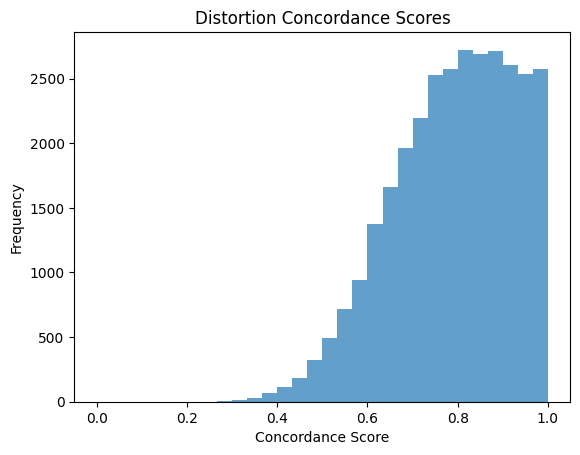

In [25]:
concordance_scores_distortion = score.concordance(out, S_X, method="distortion", bootstrap_number=-1)

# Visualize Distortion concordance scores
plt.hist(concordance_scores_distortion, bins=30, alpha=0.7)
plt.title("Distortion Concordance Scores")
plt.xlabel("Concordance Score")
plt.ylabel("Frequency")
plt.show()


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [05:15<00:00, 157.83s/it]


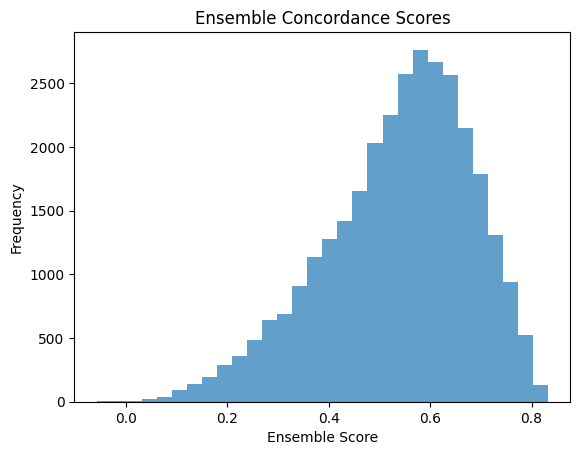

In [26]:
ensemble_scores, _ = score.ensemble_concordance(
    out, S_X, 
    methods=['spearman', 'distortion'],  # Use supported methods
    bootstrap_number=-1
)

# Visualize ensemble concordance scores
plt.hist(ensemble_scores, bins=30, alpha=0.7)
plt.title("Ensemble Concordance Scores")
plt.xlabel("Ensemble Score")
plt.ylabel("Frequency")
plt.show()


In [49]:
print(ensemble_scores)
print(len(ensemble_scores))
print(cell_type_data)

[0.74234489 0.71232103 0.56248466 ... 0.69350199 0.5907952  0.7503896 ]
31029
       Unnamed: 0        cls
0               1        ESC
1               2        ESC
2               3        ESC
3               4        ESC
4               5        ESC
...           ...        ...
31024       31025  NE-1/NS-5
31025       31026        CPs
31026       31027       SMPs
31027       31028       SMPs
31028       31029       SMPs

[31029 rows x 2 columns]


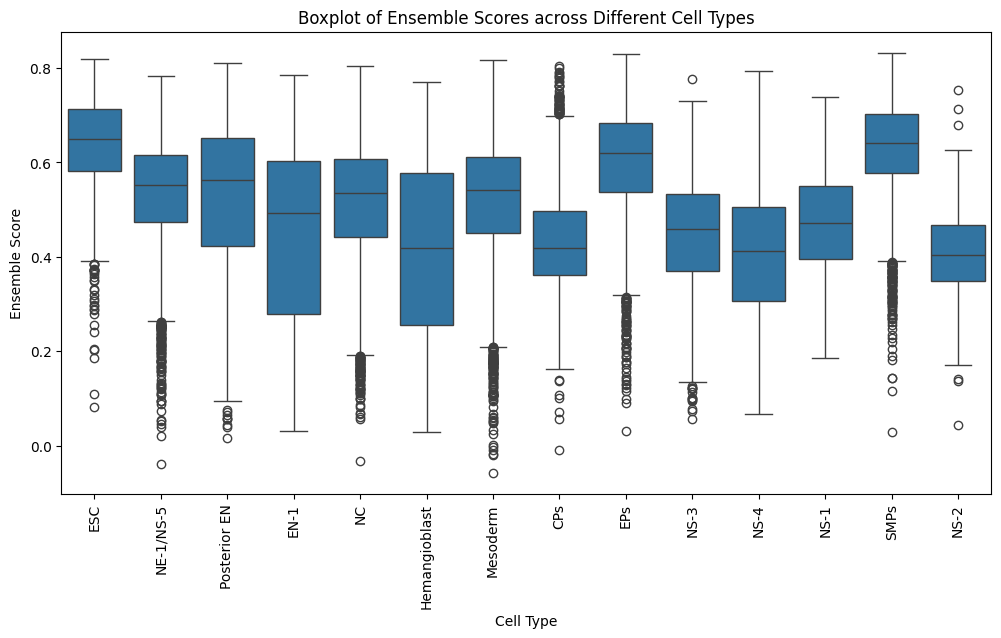

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert ensemble_scores into a DataFrame
ensemble_df = pd.DataFrame({'ensemble_score': ensemble_scores})

# Ensure `cell_type_data` is a DataFrame with correct indices
cell_type_data = cell_type_data.reset_index(drop=True)

# Merge ensemble scores with cell type labels
merged_df = pd.concat([ensemble_df, cell_type_data['cls']], axis=1)

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='cls', y='ensemble_score', data=merged_df)

# Customize the plot
plt.xticks(rotation=90)  # Rotate x-axis labels if too many categories
plt.xlabel("Cell Type")
plt.ylabel("Ensemble Score")
plt.title("Boxplot of Ensemble Scores across Different Cell Types")

# Show the plot
plt.show()


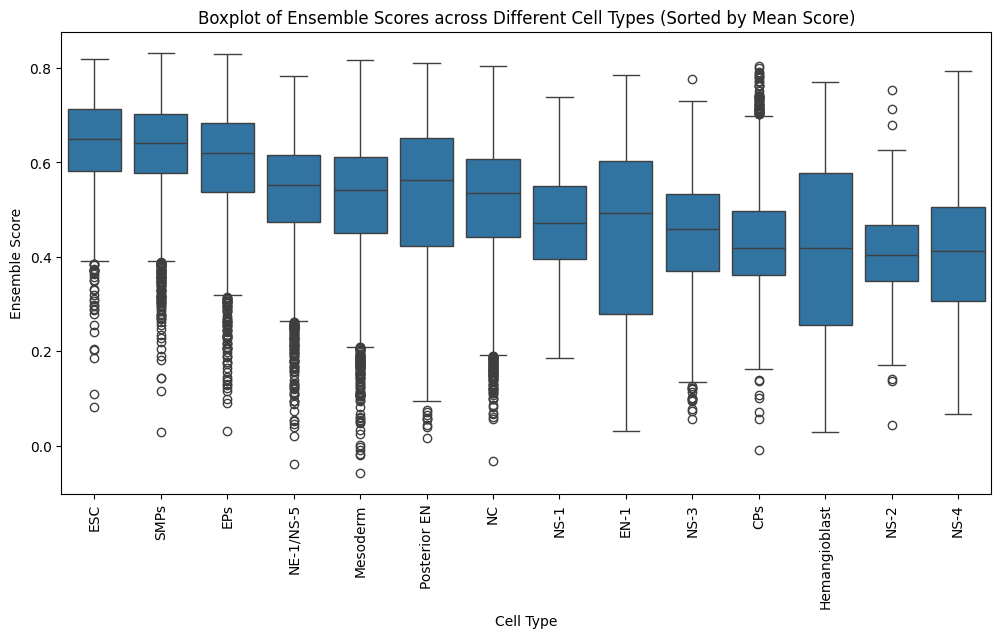

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert ensemble_scores into a DataFrame
ensemble_df = pd.DataFrame({'ensemble_score': ensemble_scores})

# Ensure `cell_type_data` is a DataFrame with correct indices
cell_type_data = cell_type_data.reset_index(drop=True)

# Merge ensemble scores with cell type labels
merged_df = pd.concat([ensemble_df, cell_type_data['cls']], axis=1)

# Compute the mean ensemble score for each cell type
mean_scores = merged_df.groupby("cls")["ensemble_score"].mean()

# Sort cell types by mean ensemble score in descending order
sorted_categories = mean_scores.sort_values(ascending=False).index

# Create the boxplot with sorted categories
plt.figure(figsize=(12, 6))
sns.boxplot(x='cls', y='ensemble_score', data=merged_df, order=sorted_categories)

# Customize the plot
plt.xticks(rotation=90)  # Rotate x-axis labels if too many categories
plt.xlabel("Cell Type")
plt.ylabel("Ensemble Score")
plt.title("Boxplot of Ensemble Scores across Different Cell Types (Sorted by Mean Score)")

# Show the plot
plt.show()


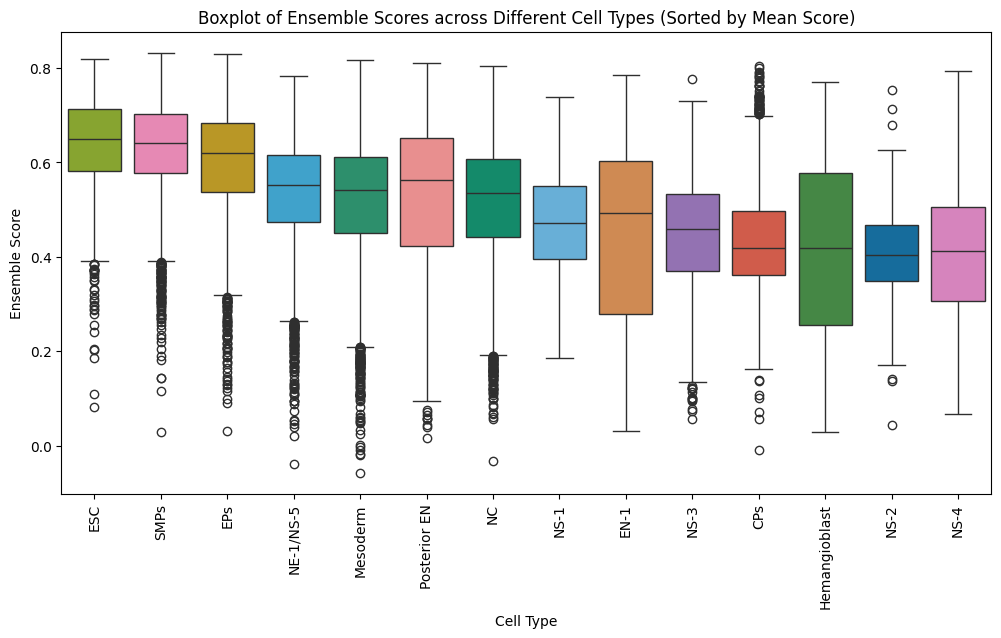

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert ensemble_scores into a DataFrame
ensemble_df = pd.DataFrame({'ensemble_score': ensemble_scores})

# Ensure `cell_type_data` is a DataFrame with correct indices
cell_type_data = cell_type_data.reset_index(drop=True)

# Merge ensemble scores with cell type labels
merged_df = pd.concat([ensemble_df, cell_type_data['cls']], axis=1)

# Compute the mean ensemble score for each cell type
mean_scores = merged_df.groupby("cls")["ensemble_score"].mean()

# Sort cell types by mean ensemble score in descending order
sorted_categories = mean_scores.sort_values(ascending=False).index

# Define a color palette (adjust colors if necessary)
custom_palette = {
    "CPs": "#E64B35", "ESC": "#91B71D", "EPs": "#D1A40E", "SMPs": "#F57AB3",
    "NS-1": "#56B4E9", "Mesoderm": "#1D9F71", "NC": "#009E73", "NS-2": "#0072B2",
    "NS-3": "#9467BD", "NS-4": "#E377C2", "Posterior EN": "#F78080",
    "Hemangioblast": "#3A923A", "EN-1": "#E4883E", "NE-1/NS-5": "#29ABE2"
}

# Create the boxplot with sorted categories and custom colors
plt.figure(figsize=(12, 6))
sns.boxplot(x='cls', y='ensemble_score', data=merged_df, order=sorted_categories, palette=custom_palette)

# Customize the plot
plt.xticks(rotation=90)  # Rotate x-axis labels if too many categories
plt.xlabel("Cell Type")
plt.ylabel("Ensemble Score")
plt.title("Boxplot of Ensemble Scores across Different Cell Types (Sorted by Mean Score)")

# Show the plot
plt.show()


# Global Stability (DynamicViz) vs Entropy

Cutoff value for the lowest 2%: 0.2642689054082454
Cutoff value for the lowest 8%: 0.3791611809904047
Cutoff value for the lowest 15%: 0.4479526903057833
Original indices of the lowest 2%: [17646, 23927, 23004, 5166, 4700, 5943, 4797, 4658, 4759, 28903, 29109, 5130, 23278, 6045, 3922, 29698, 6872, 28445, 30581, 28651, 30382, 24845, 4863, 4585, 30698, 5042, 23886, 29722, 5456, 23769, 24202, 28544, 27275, 5212, 30335, 27832, 7737, 22665, 5159, 5749, 25711, 21982, 26064, 4755, 4576, 18381, 30673, 5714, 24602, 4621, 25371, 23089, 24663, 21094, 23348, 23189, 29962, 29917, 24630, 25187, 25270, 29511, 24665, 27025, 292, 29802, 30071, 25527, 27945, 28552, 28206, 21169, 26356, 24096, 22507, 22635, 5209, 30266, 20611, 24948, 29157, 27550, 5421, 1138, 24314, 27736, 23590, 5748, 21275, 22451, 9335, 26189, 29746, 20914, 9080, 26132, 27519, 26513, 20282, 5439, 22899, 22785, 21824, 27154, 7348, 7914, 6787, 4617, 6510, 15397, 8709, 25212, 25337, 6109, 8825, 29130, 23933, 1273, 25007, 19335, 25871, 577

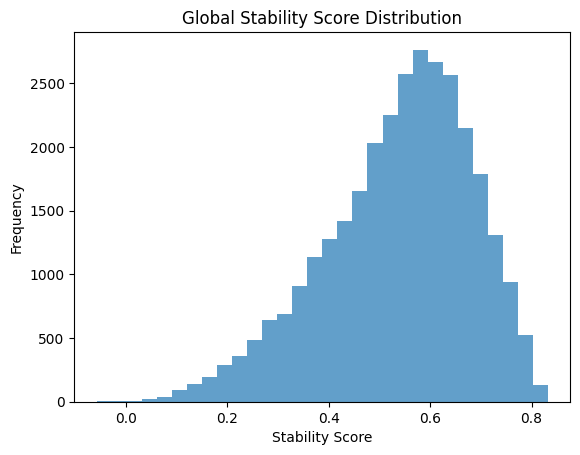

In [46]:
# Create a DataFrame for stability scores
df = pd.DataFrame(ensemble_scores, columns=['Scores'])

# Add an original index column to keep track of original positions
df['Original_Index'] = df.index

# Sort the DataFrame by scores to find the lowest percentages
sorted_df = df.sort_values(by='Scores', ascending=True)

# Determine cutoff values for the 2%, 8%, and 15% lowest scores
cutoff_2 = sorted_df.iloc[int(len(df) * 0.05 - 1)]['Scores']
print("Cutoff value for the lowest 2%:", cutoff_2)

cutoff_8 = sorted_df.iloc[int(len(df) * 0.15 - 1)]['Scores']
print("Cutoff value for the lowest 8%:", cutoff_8)

cutoff_15 = sorted_df.iloc[int(len(df) * 0.25 - 1)]['Scores']
print("Cutoff value for the lowest 15%:", cutoff_15)

# Get the original indices of the lowest n% scores
lowest_2 = sorted_df.head(int(len(df) * 0.05))['Original_Index'].tolist()
print("Original indices of the lowest 2%:", lowest_2)

lowest_8 = sorted_df.head(int(len(df) * 0.15))['Original_Index'].tolist()
print("Original indices of the lowest 8%:", lowest_8)

lowest_15 = sorted_df.head(int(len(df) * 0.25))['Original_Index'].tolist()
print("Original indices of the lowest 15%:", lowest_15)

# Creating DataFrames for the indices
df_lowest_2 = pd.DataFrame(lowest_2, columns=['x'])
df_lowest_8 = pd.DataFrame(lowest_8, columns=['x'])
df_lowest_15 = pd.DataFrame(lowest_15, columns=['x'])

# Define base file name (customize this as per your requirements)
base_filename = 'embryoid_body_dynamicViz_global_stability'

# Saving DataFrames to CSV with proper formatting
df_lowest_2.to_csv(f'{base_filename}_2_p2000_pc10.csv', index=True)
df_lowest_8.to_csv(f'{base_filename}_10_p2000_pc10.csv', index=True)
df_lowest_15.to_csv(f'{base_filename}_20_p2000_pc10.csv', index=True)

print(len(ensemble_scores))
print(len(lowest_2))
print(len(lowest_8))
print(len(lowest_15))

# Optionally visualize the distribution of scores
plt.hist(ensemble_scores, bins=30, alpha=0.7)
plt.title("Global Stability Score Distribution")
plt.xlabel("Stability Score")
plt.ylabel("Frequency")
plt.show()


In [62]:
print(df_lowest_2)

       x
0    890
1    123
2   1510
3   1157
4   1638
..   ...
64   305
65  3288
66  2758
67   304
68    92

[69 rows x 1 columns]


# don't use boostrapping

In [3]:
# Load the data
data = pd.read_csv("murine_preprocessed.csv")
data.name = "intestinal"

# Convert the selected columns to a NumPy matrix and transpose it
scale_data = data.iloc[:, 8:2008].to_numpy().T

cls = data['cell_type'].astype('category')

# Applying SVD with k=30
u, s, vt = svds(scale_data, k=30)

# Singular values in descending order
eg_v = s[::-1]  # svds returns them in ascending order

ratios = eg_v[:-1] / eg_v[1:]

# Plot (eg.v[1:29] - eg.v[2:30]) / eg.v[2:30]
differences = (eg_v[:-1] - eg_v[1:]) / eg_v[1:]

# Find the maximum index where the ratio > 1.2
max_index_1_2 = np.max(np.where(ratios > 1.2))
print("Max index where ratio > 1.2:", max_index_1_2)

# Effect of perplexity: find the maximum index where the ratio > 1.1
pc = np.max(np.where(ratios > 1.1)) + 1  # +1 to match R's 1-based index
print("PC (perplexity component):", pc)

# Apply SVD again with k=pc
u_pc, s_pc, vt_pc = svds(scale_data, k=pc)

# Denoise the data: svd.data$v %*% diag(svd.data$d)
data_denoise = vt_pc.T @ np.diag(s_pc)
print("Denoised data shape:", data_denoise.shape)

# Set N=30 (for further analysis if needed)
N = 30

Max index where ratio > 1.2: 3
PC (perplexity component): 10
Denoised data shape: (3452, 10)


In [22]:
import pandas as pd
import numpy as np

# Load the Y matrix (t-SNE coordinates) from the CSV file
tsne_data = pd.read_csv("intestinal_tsne_random_p30_pc10_Y_matrix.csv", index_col=0)

# Convert to NumPy array
Y = tsne_data.to_numpy()  # Assuming the file contains only the 2D t-SNE coordinates
print("t-SNE coordinates shape:", Y.shape)



t-SNE coordinates shape: (3452, 2)


In [16]:
cls_data = pd.read_csv("intestinal_cls.csv", index_col=0)
cls = cls_data.to_numpy().flatten()  # Convert to a 1D NumPy array
print("Cell type labels shape:", cls.shape)
print(cls)

Cell type labels shape: (3452,)
['TA cells' '2' '2' ... 'Stem cells' 'Stem cells' 'Stem cells']


In [11]:

import pandas as pd
import numpy as np
import os

# Initialize an empty list to store all iterations
knn_mat_list = []

# Loop through all 30 iterations
for i in range(1, 31):  # Assuming 30 iterations
    # Correctly define the file path
    file_path = os.path.join(f"knn_mat_iteration_{i}.csv")
    
    # Load the CSV file as a NumPy array
    knn_matrix = pd.read_csv(file_path).to_numpy()
    
    # Append the matrix to the list
    knn_mat_list.append(knn_matrix)

# Check the structure
print(f"Loaded {len(knn_mat_list)} iterations")
print(f"Shape of one iteration: {knn_mat_list[0].shape}")





Loaded 30 iterations
Shape of one iteration: (3452, 50)


In [16]:
# Print the second element of knn_mat_list
print(knn_mat_list[0])
print(knn_mat_list[1])


[[  87   42 2409 ... 1398 1724 2687]
 [1052 1665 1560 ... 1189  108 1564]
 [   8  183  164 ... 2871 1574 2777]
 ...
 [3226 2895 3092 ... 2660 1537 2596]
 [ 824 1389 3130 ... 2695  424  586]
 [1965 2444 2770 ... 2371 3338 2494]]
[[  87   42 2409 ...  224 1093 1218]
 [1052 1665 1059 ... 1408  108 1569]
 [   8  183  164 ... 1332 1574 2871]
 ...
 [3226 1535 1352 ... 3431 2069 1209]
 [ 824 3130  346 ... 2332 2766 1388]
 [1965  657 1570 ... 2822 1239 2046]]


In [18]:
from collections import defaultdict  # Import defaultdict

# Aggregate neighbors for each point across all iterations
aggregated_neighbors = defaultdict(set)

for iteration in knn_mat_list:
    for i, neighbors in enumerate(iteration):  # i is the row index, neighbors are columns
        aggregated_neighbors[i].update(neighbors)

# Convert aggregated neighbors to a list of lists
aggregated_knn = [list(neighbors) for neighbors in aggregated_neighbors.values()]

# Verify the structure
print(f"Number of aggregated neighbors: {len(aggregated_knn)}")
print(f"Example aggregated neighbors for point 0: {aggregated_knn[0]}")



Number of aggregated neighbors: 3452
Example aggregated neighbors for point 0: [1030, 12, 1554, 25, 27, 2590, 2078, 1065, 42, 53, 56, 2616, 1082, 1087, 2623, 2625, 1601, 3139, 67, 1093, 1614, 78, 1616, 3154, 1106, 87, 607, 101, 104, 617, 2155, 1142, 121, 2687, 128, 127, 1678, 1167, 144, 142, 2191, 1685, 2713, 3238, 1724, 1218, 1220, 2247, 2761, 3274, 726, 1242, 2270, 224, 3313, 1779, 1279, 1792, 1793, 1309, 3366, 2343, 2856, 3382, 1336, 2875, 1343, 1346, 1347, 838, 1365, 1879, 861, 1373, 862, 2406, 2409, 873, 3438, 3440, 1398, 2423, 1402, 1403, 2946, 391, 1415, 1418, 1937, 2963, 1443, 2981, 1446, 2471, 936, 1457, 1464, 1465, 452, 3012, 454, 3027, 1491, 2524, 3048, 496, 1530, 3067]


In [27]:
# Create a DataFrame for the t-SNE coordinates
df = pd.DataFrame(Y, columns=["x1", "x2"])

# Add an "original_index" column to mimic the structure expected by DynamicViz
df["original_index"] = range(len(Y))

print(df.head())


          x1        x2  original_index
0 -27.108392 -5.167541               0
1 -38.838721  0.132320               1
2 -42.115951  3.179270               2
3  25.461193  1.670761               3
4   8.496129  4.325220               4


In [28]:
# Compute local variance scores
variance_scores_local = score.variance(df=df, neighborhoods=aggregated_knn, method="local", k=50)
print("Local Variance Scores:", variance_scores_local)

# Compute stability scores from variance scores
stability_scores = score.stability_from_variance(variance_scores_local, alpha=20)
print("Stability Scores:", stability_scores)




KeyError: 'bootstrap_number'

In [ ]:
# Histogram of variance scores
plt.hist(variance_scores_local, bins=20, alpha=0.7, label="Local Variance")
plt.legend()
plt.title("Variance Score Distribution")
plt.xlabel("Variance Score")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of stability vs variance
plt.scatter(stability_scores, variance_scores_local, alpha=0.7)
plt.title("Stability vs Variance")
plt.xlabel("Stability Score")
plt.ylabel("Variance Score")
plt.show()


In [ ]:
# Combine t-SNE results (Y) and stability scores into a DataFrame
df = pd.DataFrame(Y, columns=["tSNE_1", "tSNE_2"])
df["stability_score"] = stability_scores

# Interactive visualization
fig = viz.interactive(df, 'stability_score', show=True, save="stability_visualization.html",
                      alpha=0.5, legend_title="Stability Score", dpi=150)

# Static visualization
fig = viz.stacked(df, 'stability_score', show=True, save="stability_visualization.png",
                  xlabel="t-SNE 1", ylabel="t-SNE 2", dpi=150, marker="x", s=20,
                  cmap='coolwarm', show_legend=True)


# Multiple Iterations

In [4]:
import pandas as pd
import numpy as np
from dynamicviz.viz import interactive, animated, stacked

# Assume `data_denoise` is a high-dimensional dataset (after SVD denoising or similar)

# Step 1: Apply a dimensionality reduction method, e.g., t-SNE to reduce to 2D
from sklearn.manifold import TSNE
embedded_data = TSNE(n_components=2, random_state=42).fit_transform(data_denoise)

# Step 2: Create a DataFrame for visualization
df_viz = pd.DataFrame(embedded_data, columns=['x1', 'x2'])
df_viz['label'] = np.random.choice(['Type A', 'Type B', 'Type C'], size=len(df_viz))

# Step 3: Visualize using dynamicviz
# Interactive visualization
fig = interactive(df_viz, label='label', show=True, title='Interactive t-SNE Visualization')

# Or create an animated visualization with bootstrapping (if you have multiple iterations)


/opt/anaconda3/envs/dynamic/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/dynamic/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: Value of 'animation_group' is not the name of a column in 'data_frame'. Expected one of ['x1', 'x2', 'label'] but received: original_index